Temp Diff is 0.3909903758184283
Total Social Costs of 1 year of meat production are 212.89271948912614 Billion dollars


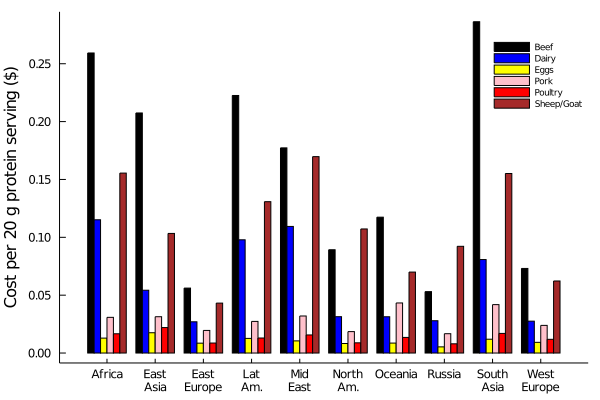

In [30]:
include("The_high_social_costs_of_animal_based_foods_ALLRESULTS.jl")

In [2]:
using Plots, NLopt, DataFrames, CSV

directory = dirname(pwd())
subroutine_directory = joinpath(directory, "src", "SubRoutines_SCW")
output_directory = joinpath(directory, "Results", "SCW")

include(joinpath(subroutine_directory, "AnimalWelfareModel.jl"))
include(joinpath(subroutine_directory, "helpers_SCWOptimization.jl"))
DICEFARM = create_AnimalWelfare()
run(DICEFARM)
println("Ran once")
BaseWelfare = DICEFARM[:welfare, :UTILITY]
MargCons 	= create_AnimalWelfare()
update_param!(MargCons, :CEQ, 1e-9)  #dropping C by 1000 globally
run(MargCons)
MargConsWelfare = MargCons[:welfare, :UTILITY]
SCNumeraire 	= BaseWelfare - MargConsWelfare

SocialCosts = zeros(4) # Vegetarian; then each of 3 animal products

# ----- Need original amount consumed -------- #
OrigBeef = DICEFARM[:farm, :Beef]
OrigPork = DICEFARM[:farm, :Pork]
OrigPoultry = DICEFARM[:farm, :Poultry]

# ------ Add Vegetarian average pulse ------------------- #
BeefPulse = copy(OrigBeef)
PorkPulse = copy(OrigPork)
PoultryPulse = copy(OrigPoultry)

BeefPulse[TwentyTwenty] = OrigBeef[TwentyTwenty] + 1000*(4.8) 				
PorkPulse[TwentyTwenty] = OrigPork[TwentyTwenty]  + 1000*(2.7)
PoultryPulse[TwentyTwenty] = OrigPoultry[TwentyTwenty] + 1000*(6.7)

VegPulse = create_AnimalWelfare()
update_param!(VegPulse, :Beef, BeefPulse)
update_param!(VegPulse, :Poultry, PoultryPulse)
update_param!(VegPulse, :Pork, PorkPulse)

run(VegPulse)
VegWelfare = VegPulse[:welfare, :UTILITY]
SCCVeg     = (BaseWelfare - VegWelfare)/(SCNumeraire)



Ran once


127211.04918032787

In [6]:
Meats = [:Beef, :Pork, :Poultry]
Origs = [OrigBeef, OrigPork, OrigPoultry]
SCs = ones(3)
i = collect(1:1:length(Meats))
for (meat, O, i) in zip(Meats, Origs, i)
	tempM = create_AnimalWelfare()
    update_param!(tempM, :rho, .000001)
    #update_param!(tempM, :a2, 0.)
    update_param!(tempM, :dam_gama, .00001)
	update_param!(tempM, :thetaB, .01)
	update_param!(tempM, :thetaC, .01)
	update_param!(tempM, :thetaP, .01)
    #update_param!(tempM, :CowEquiv, 1.9)
    #update_param!(tempM, :PigEquiv, 1.9)
    #update_param!(tempM, :ChickenEquiv, 1.9)
	run(tempM)
	TempBaseWelfare = tempM[:welfare, :UTILITY]
    
    m_cons = create_AnimalWelfare()
    update_param!(m_cons, :rho, .000001)
    #update_param!(m_cons, :a2, 0.)
    update_param!(m_cons, :dam_gama, .00001)
	update_param!(m_cons, :thetaB, .01)
	update_param!(m_cons, :thetaC, .01)
	update_param!(m_cons, :thetaP, .01)
    #update_param!(m_cons, :CowEquiv, 1.9)
    #update_param!(m_cons, :PigEquiv, 1.9)
    #update_param!(m_cons, :ChickenEquiv, 1.9)
    update_param!(m_cons, :CEQ, 1e-3)
    run(m_cons)
    cons_change = m_cons[:welfare, :UTILITY]

	MPulse = copy(O)
	MPulse[TwentyTwenty] = MPulse[TwentyTwenty] + 1000000000*.02 				

	M = create_AnimalWelfare()
    update_param!(M, :rho, .000001)
    #update_param!(M, :a2, 0.)
    update_param!(M, :dam_gama, .00001)
	update_param!(M, :thetaB, .01)
	update_param!(M, :thetaP, .01)
	update_param!(M, :thetaC, .01)
    #update_param!(M, :CowEquiv, 1.9)
    #update_param!(M, :PigEquiv, 1.9)
    #update_param!(M, :ChickenEquiv, 1.9)
	update_param!(M, meat, MPulse)
	run(M)
	MWelfare = M[:welfare, :UTILITY]
	SCs[i] = (TempBaseWelfare - MWelfare)/(TempBaseWelfare - cons_change)
    plot(tempM[:welfare, :CPC][TwentyTwenty-1:TwentyTwenty+480], label="Cons Pulse")
    plot!(M[:welfare, :CPC][TwentyTwenty-1:TwentyTwenty+480], label="Meat Pulse", legend=:topleft)
    savefig("tempplot.pdf")
end
SCs

3-element Array{Float64,1}:
 1.257062247165305
 0.4583103796116875
 3.340224695731752

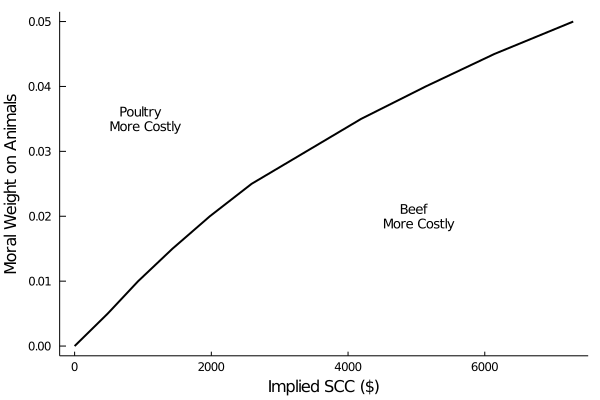

In [3]:
Thetas = collect(0.005:.005:.05)
SCCs   = zeros(length(Thetas))
Beef_serving_Pulse = copy(OrigBeef)
Beef_serving_Pulse[TwentyTwenty] = Beef_serving_Pulse[TwentyTwenty] + 100000*.02
Poultry_serving_Pulse = copy(OrigPoultry)
Poultry_serving_Pulse[TwentyTwenty] = Poultry_serving_Pulse[TwentyTwenty] + 100000*.02
rho = .000001
dam_gama  = .0001
for (i, theta) in enumerate(Thetas)
	marg_welfare_diff = 0.
	while marg_welfare_diff<1.
		dam_gama  = 1.002*dam_gama
		m1  = create_AnimalWelfare()
		m2  = create_AnimalWelfare()
		update_param!(m1, :rho, rho)
		update_param!(m1, :dam_gama, dam_gama)
        update_param!(m1, :thetaB, theta)
        update_param!(m1, :thetaC, theta)
        update_param!(m1, :thetaP, theta)
		update_param!(m1, :Beef, Beef_serving_Pulse)
		update_param!(m2, :rho, rho)
		update_param!(m2, :dam_gama, dam_gama)
        update_param!(m2, :thetaB, theta)
        update_param!(m2, :thetaC, theta)
        update_param!(m2, :thetaP, theta)
		update_param!(m2, :Poultry, Poultry_serving_Pulse)
		run(m1)
		run(m2)
		marg_welfare_diff = m2[:welfare, :UTILITY]/m1[:welfare, :UTILITY]
	end
	#Compute implied SCC for this combination
	base_welfare_for_scc = create_AnimalWelfare()
	update_param!(base_welfare_for_scc, :rho, rho)
	update_param!(base_welfare_for_scc, :dam_gama, dam_gama)
	run(base_welfare_for_scc)
	marg_cons_for_scc   = create_AnimalWelfare()
	update_param!(marg_cons_for_scc, :rho, rho)
	update_param!(marg_cons_for_scc, :dam_gama, dam_gama)
	update_param!(marg_cons_for_scc, :CEQ, 1e-9)
	run(marg_cons_for_scc)
	Co2_pulse_for_scc   = create_AnimalWelfare()
	update_param!(Co2_pulse_for_scc, :rho, rho)
	update_param!(Co2_pulse_for_scc, :dam_gama, dam_gama)
	update_param!(Co2_pulse_for_scc, :Co2Pulse, 1.)
    run(Co2_pulse_for_scc)
	SCCs[i] = 1e-6*(base_welfare_for_scc[:welfare, :UTILITY] - Co2_pulse_for_scc[:welfare, :UTILITY])/(base_welfare_for_scc[:welfare, :UTILITY] - marg_cons_for_scc[:welfare, :UTILITY])
end
Figure5df = DataFrame(SCCs = [0; SCCs], Theta = [0; Thetas])
CSV.write(joinpath(output_directory, "Figure5.csv"), Figure5df)
plot([0; SCCs], [0; Thetas], label="", grid=false, legend=:topleft, linecolor=:black, linewidth=2, ylabel="Moral Weight on Animals", xlabel="Implied SCC (\$)")
annotate!([(5000, .02, Plots.text("Beef \n More Costly", 9, :black))])
annotate!([(1000, .035, Plots.text("Poultry \n More Costly", 9, :black))])

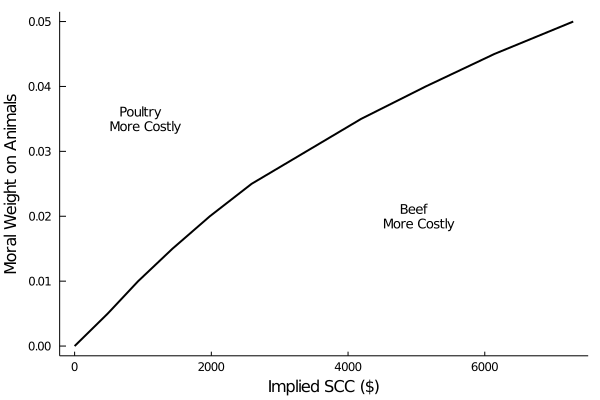

In [4]:
Figure5df = DataFrame(SCCs = [0; SCCs], Theta = [0; Thetas])
CSV.write(joinpath(output_directory, "Figure5.csv"), Figure5df)
plot([0; SCCs], [0; Thetas], label="", grid=false, legend=:topleft, linecolor=:black, linewidth=2, ylabel="Moral Weight on Animals", xlabel="Implied SCC (\$)")
annotate!([(5000, .02, Plots.text("Beef \n More Costly", 9, :black))])
annotate!([(1000, .035, Plots.text("Poultry \n More Costly", 9, :black))])

In [ ]:
include("SCW_AllResults.jl")

Ran once


┌ Warning: Assignment to `BeefPulse` in soft scope is ambiguous because a global variable by the same name exists: `BeefPulse` will be treated as a new local. Disambiguate by using `local BeefPulse` to suppress this warning or `global BeefPulse` to assign to the existing global variable.
└ @ nothing C:\Users\Kevin\Documents\GitHub\DICEFARM\src\SCW_AllResults.jl:56
┌ Warning: Assignment to `PorkPulse` in soft scope is ambiguous because a global variable by the same name exists: `PorkPulse` will be treated as a new local. Disambiguate by using `local PorkPulse` to suppress this warning or `global PorkPulse` to assign to the existing global variable.
└ @ nothing C:\Users\Kevin\Documents\GitHub\DICEFARM\src\SCW_AllResults.jl:57
┌ Warning: Assignment to `PoultryPulse` in soft scope is ambiguous because a global variable by the same name exists: `PoultryPulse` will be treated as a new local. Disambiguate by using `local PoultryPulse` to suppress this warning or `global PoultryPulse` to assig

Costs of Non-Veg in Baseline are 127211.04918032787


┌ Warning: Assignment to `BeefPulse` in soft scope is ambiguous because a global variable by the same name exists: `BeefPulse` will be treated as a new local. Disambiguate by using `local BeefPulse` to suppress this warning or `global BeefPulse` to assign to the existing global variable.
└ @ nothing C:\Users\Kevin\Documents\GitHub\DICEFARM\src\SCW_AllResults.jl:94
┌ Warning: Assignment to `PorkPulse` in soft scope is ambiguous because a global variable by the same name exists: `PorkPulse` will be treated as a new local. Disambiguate by using `local PorkPulse` to suppress this warning or `global PorkPulse` to assign to the existing global variable.
└ @ nothing C:\Users\Kevin\Documents\GitHub\DICEFARM\src\SCW_AllResults.jl:95
┌ Warning: Assignment to `PoultryPulse` in soft scope is ambiguous because a global variable by the same name exists: `PoultryPulse` will be treated as a new local. Disambiguate by using `local PoultryPulse` to suppress this warning or `global PoultryPulse` to assig

Costs of Beef in Baseline are 56.43793911007026
Costs of Pork in Baseline are 32.859484777517565
Costs of Poultry in Baseline are 326.0608899297424
Optimal Vegetarian Reduction is [0.4397876262785221]


In [8]:
include("SubRoutines_SCW//AnimalWelfareModel.jl")
include("SubRoutines_SCW//SCCs.jl")

Baseline SCC is 31.062029257611236
Ran once
Stern SCC is 246.5016615862069
Ran once
Growth Damage is 32.518197868852454
Ran once
Growth Damage + Stern 268.1369115862069


In [21]:
rho = .00001
dam_gama = 1.1*.00001
theta = .1
		m1  = create_AnimalWelfare()
		m2  = create_AnimalWelfare()
		update_param!(m1, :rho, rho)
		update_param!(m1, :dam_gama, dam_gama)
        update_param!(m1, :thetaB, theta)
        update_param!(m1, :thetaC, theta)
        update_param!(m1, :thetaP, theta)
		update_param!(m1, :Beef, Beef_serving_Pulse)
		update_param!(m2, :rho, rho)
		update_param!(m2, :dam_gama, dam_gama)
        update_param!(m2, :thetaB, theta)
        update_param!(m2, :thetaC, theta)
        update_param!(m2, :thetaP, theta)
		update_param!(m2, :Poultry, Poultry_serving_Pulse)
		run(m1)
		run(m2)
        m1[:welfare,:UTILITY]
        m2[:welfare, :UTILITY]
m1[:welfare, :UTILITY]/m2[:welfare,:UTILITY]

0.9999370766743158

0.9999948045111011

In [23]:
function opttest(x, grad)
	if length(grad)>0
	grad[1] = 1000
    grad[2] = 5
	end
	result = x[1]^2 - x[2]^2
	return result
end
opt = Opt(:LN_SBPLX, 2)
opt.lower_bounds=-1*ones(2)
opt.upper_bounds=ones(2)
init = [-.4; .6]
opt.xtol_rel = 1e-17
opt.max_objective = opttest
sol2 = optimize(opt, init)

(1.0, [1.0, 6.901154694927138e-9], :XTOL_REACHED)

In [37]:
 collect(0.1:.4:.9)

3-element Array{Float64,1}:
 0.1
 0.5
 0.9

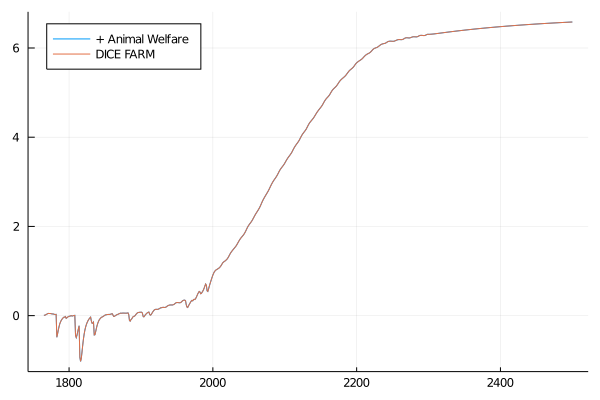

In [66]:
plot(collect(1765:1:2500), mm[:temperature, :T], label="+ Animal Welfare")
plot!(collect(1765:1:2500), m[:temperature, :T], label="DICE FARM", legend=:topleft)

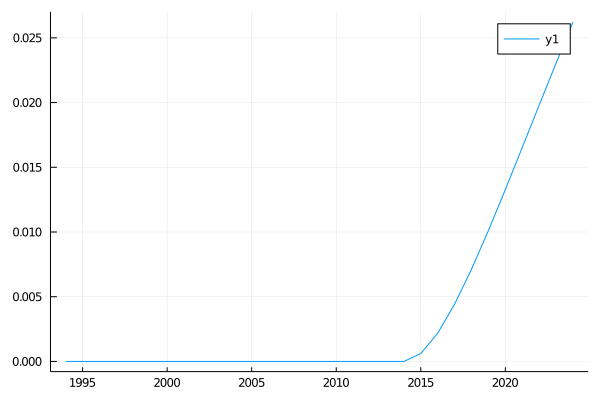

In [50]:
diff = m[:temperature, :T] - mm[:temperature, :T]
plot(collect(1765:1:2500)[230:260], diff[230:260])

In [58]:
testT = 200
t = collect(2010:1:2009+testT)
TFP = ones(testT)
TFP[1] = 5.115
gA= ones(testT)
gA[1] = 0.018
for i = 2:testT
    gA[i] = exp(-.006*(i-1))*gA[1]
    TFP[i] = TFP[i-1]/(1-gA[i-1])
end
[t TFP gA]

200×3 Array{Float64,2}:
 2010.0   5.115    0.018
 2011.0   5.20876  0.0178923
 2012.0   5.30365  0.0177853
 2013.0   5.39969  0.0176789
 2014.0   5.49687  0.0175731
 2015.0   5.59519  0.017468
 2016.0   5.69467  0.0173635
 2017.0   5.79529  0.0172597
 2018.0   5.89707  0.0171564
 2019.0   6.00001  0.0170538
 2020.0   6.10411  0.0169518
 2021.0   6.20937  0.0168504
 2022.0   6.31579  0.0167496
    ⋮              
 2198.0  39.6264   0.00582624
 2199.0  39.8586   0.00579139
 2200.0  40.0908   0.00575674
 2201.0  40.3229   0.00572231
 2202.0  40.555    0.00568807
 2203.0  40.787    0.00565405
 2204.0  41.0189   0.00562023
 2205.0  41.2507   0.0055866
 2206.0  41.4825   0.00555319
 2207.0  41.7141   0.00551997
 2208.0  41.9457   0.00548695
 2209.0  42.1771   0.00545412

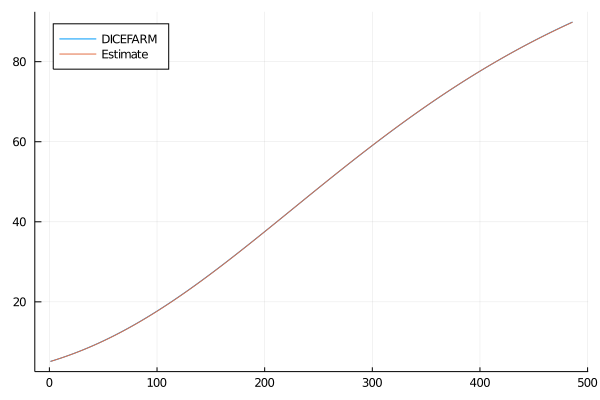

In [80]:

run(m)
DICEFARM_TFP = m[:grosseconomy, :AL][2015-1764:end]
function TFPestimates(x, grad)
	if length(grad)>0
	grad[1] = 1000
    grad[2] = 5
	end
    TFP    = ones(length(DICEFARM_TFP))
    TFP[1] = 5.115
    gA= ones(length(DICEFARM_TFP))
    gA[1] = x[1]
    for i = 2:length(gA)
        gA[i] = exp(x[2]*(i-1))*gA[1]
        TFP[i] = TFP[i-1]/(1-gA[i-1])
    end
	result = sum((DICEFARM_TFP - TFP).^2)
	return result
end
opt = Opt(:LN_SBPLX, 2)
opt.lower_bounds=[0.; -Inf]
opt.upper_bounds=[.02; 0.]
init = [.015; -.005]
opt.xtol_rel = 1e-17
opt.min_objective = TFPestimates
sol2 = optimize(opt, init)[2]
TFP    = ones(length(DICEFARM_TFP))
TFP[1] = 5.115
gA= ones(length(DICEFARM_TFP))
gA[1] = sol2[1]
for i = 2:length(gA)
     gA[i] = exp(sol2[2]*(i-1))*gA[1]
     TFP[i] = TFP[i-1]/(1-gA[i-1])
end


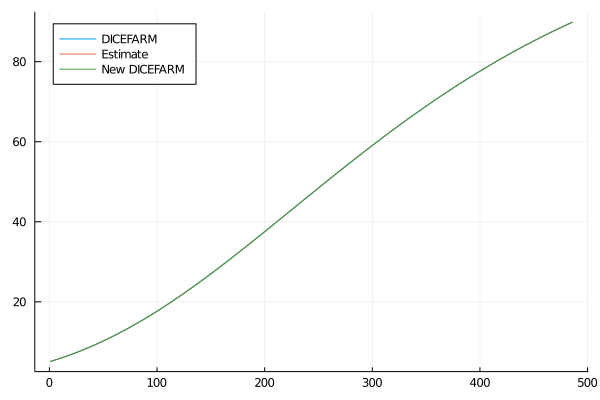

In [99]:
plot(DICEFARM_TFP, label="DICEFARM")
plot!(TFP, label="Estimate", legend=:topleft)
plot!(DICEFARM_TFP_2, label="New DICEFARM")

In [5]:
include("DICEFARM.jl")

create_dice_farm (generic function with 1 method)

In [6]:
m = create_dice_farm()

Mimi.Model
  Module: Mimi
  Components:
    ComponentId(Main.grosseconomy)
    ComponentId(Main.farm)
    ComponentId(Main.emissions)
    ComponentId(MimiFAIR.ch4_cycle)
    ComponentId(MimiFAIR.n2o_cycle)
    ComponentId(MimiFAIR.other_ghg_cycles)
    ComponentId(MimiFAIR.co2_cycle)
    ComponentId(MimiFAIR.ch4_rf)
    ComponentId(MimiFAIR.n2o_rf)
    ComponentId(MimiFAIR.other_ghg_rf)
    ComponentId(MimiFAIR.co2_rf)
    ComponentId(MimiFAIR.trop_o3_rf)
    ComponentId(MimiFAIR.strat_o3_rf)
    ComponentId(MimiFAIR.aerosol_direct_rf)
    ComponentId(MimiFAIR.aerosol_indirect_rf)
    ComponentId(MimiFAIR.bc_snow_rf)
    ComponentId(MimiFAIR.landuse_rf)
    ComponentId(MimiFAIR.contrails_rf)
    ComponentId(MimiFAIR.total_rf)
    ComponentId(MimiFAIR.temperature)
    ComponentId(Main.damages)
    ComponentId(Main.neteconomy)
    ComponentId(Main.welfare)
  Built: true


In [39]:
TwentyTwenty

256

In [ ]:
Thetas = collect(0.1:.4:.9)
SCCs   = zeros(length(Thetas))
Beef_serving_Pulse = copy(OrigBeef)
Beef_serving_Pulse[TwentyTwenty] = Beef_serving_Pulse[TwentyTwenty] + 100000*.02
Poultry_serving_Pulse = copy(OrigPoultry)
Poultry_serving_Pulse[TwentyTwenty] = Poultry_serving_Pulse[TwentyTwenty] + 100000*.02
rho = .015
a2  = .0023600
dam_gama = .0001
marg_welfare_diff = 0.
	while marg_welfare_diff<1.
		rho = 0.1*rho
		a2  = 1.02*a2
        dam_gama = 1.02*dam_gama
		m1  = create_AnimalWelfare()
		m2  = create_AnimalWelfare()
		update_param!(m1, :rho, rho)
		update_param!(m1, :a2, a2)
        update_param!(m1, :dam_gama, dam_gama)
        update_param!(m1, :thetaB, .05)
        update_param!(m1, :thetaP, .05)
        update_param!(m1, :thetaC, .05)
		update_param!(m1, :Beef, Beef_serving_Pulse)
		update_param!(m2, :rho, rho)
		update_param!(m2, :a2, a2)
        update_param!(m2, :dam_gama, dam_gama)
        update_param!(m2, :thetaB, .05)
        update_param!(m2, :thetaP, .05)
        update_param!(m2, :thetaC, .05)
		update_param!(m2, :Poultry, Poultry_serving_Pulse)
		run(m1)
		run(m2)
		marg_welfare_diff = m2[:welfare, :UTILITY]/m1[:welfare, :UTILITY]		
        print(marg_welfare_diff)
	end
	#Compute implied SCC for this combination
    print(rho, a2)
	base_welfare_for_scc = create_AnimalWelfare()
	update_param!(base_welfare_for_scc, :rho, rho)
	update_param!(base_welfare_for_scc, :a2, a2)
    update_param!(base_welfare_for_scc, :dam_gama, dam_gama)
	run(base_welfare_for_scc)
	marg_cons_for_scc   = create_AnimalWelfare()
	update_param!(marg_cons_for_scc, :rho, rho)
	update_param!(marg_cons_for_scc, :a2, a2)
    update_param!(marg_cons_for_scc, :dam_gama, dam_gama)
	update_param!(marg_cons_for_scc, :CEQ, 1e-9)
	run(marg_cons_for_scc)
	Co2_pulse_for_scc   = create_AnimalWelfare()
	update_param!(Co2_pulse_for_scc, :rho, rho)
	update_param!(Co2_pulse_for_scc, :a2, a2)
    update_param!(co2_pulse_for_scc, :dam_gama, dam_gama)
	update_param!(Co2_pulse_for_scc, :Co2Pulse, 1.)
	SCCs[i] = 1e-6*(base_welfare_for_scc[:welfare, :UTILITY] - Co2_pulse_for_scc[:welfare, :UTILITY])/(base_welfare_for_scc[:welfare, :UTILITY] - marg_cons_for_scc[:welfare, :UTILITY])
end
plot(SCCs, Thetas)

0.99999999999497660.99999999999648730.9999999999966260.99999999999664480.99999999999664750.99999999999666270.9999999999966670.99999999999667480.99999999999668410.99999999999669180.9999999999966970.99999999999670620.99999999999671430.99999999999672350.9999999999967310.99999999999673890.99999999999674770.99999999999675690.99999999999676470.99999999999677350.99999999999678510.99999999999679630.9999999999968050.99999999999681120.99999999999682410.99999999999683230.9999999999968470.99999999999685550.99999999999686620.99999999999688740.99999999999689740.99999999999690560.99999999999692050.99999999999693320.99999999999694840.99999999999695890.99999999999697220.99999999999698740.9999999999970010.99999999999702040.99999999999703150.99999999999705010.99999999999706020.99999999999707430.999999999997080.99999999999710910.99999999999712760.99999999999712190.99999999999713860.99999999999717580.99999999999719150.99999999999721890.99999999999724430.99999999999725110.99999999999726260.99999999999729120

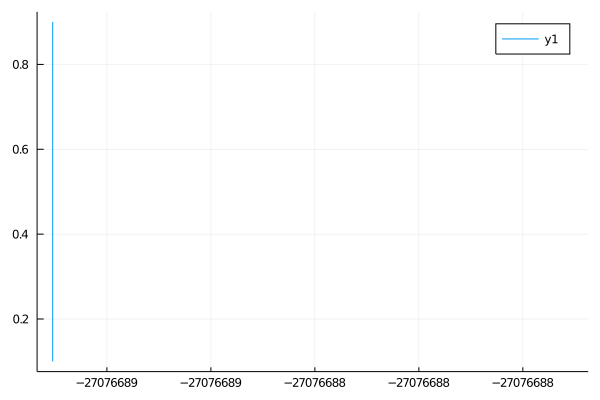

In [43]:
plot(SCCs, Thetas)